In [1]:
from helper import generate_2d_ising_observable_data, plot_error_vs_depth

Define parameters

In [ ]:
J = 1
g = 0.5
dt = 0.1
num_rows = 3
num_cols = 4
pad = 2

thresholds = [0]
max_bonds = [8, 16, 32]
timesteps_list = range(1, 55, 5)

In [ ]:
results = generate_2d_ising_observable_data(num_rows, num_cols, J, g, dt, pad, thresholds, max_bonds, timesteps_list)

Max Bond 8
TDVP Max Bond 4
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8


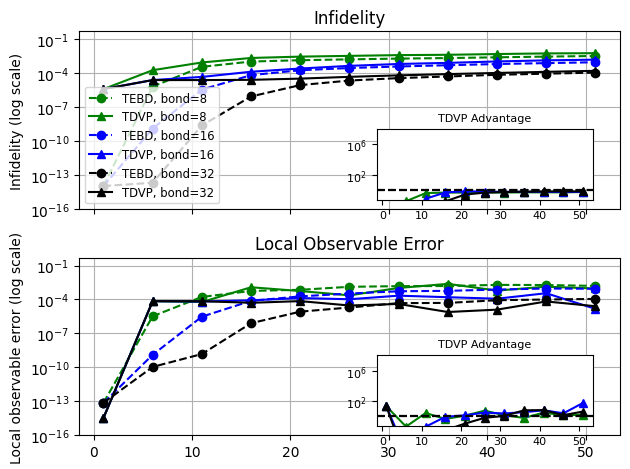

In [ ]:
plot_error_vs_depth(results, max_bonds)